## Time Series Forecasting through Extreme Learning Machine

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

### Functions

In [2]:
def mse_function(Y, Y_pred):
    
    M, C = Y.shape[0], Y.shape[1] # Number of examples (M) and number of outputs (C)

    E = Y-Y_pred # Error between Y true and Y predicted
    mse = np.sum(E.T.dot(E))/(M*C) # Mean squared error
    
    return mse

In [3]:
class MinMaxNormalization():
    
    def __init__(self, new_range):

        # Range desired
        self.a = new_range[0] # Min value
        self.b = new_range[1] # Max value

    def fit(self, X, y=None):

        self.xmin, self.xmax = X.min(), X.max() # Min and max values of data

        return self

    def transform(self, X):

        X_transform = self.a + ( (X-self.xmin)*(self.b-self.a)/(self.xmax-self.xmin) ) # Normalized data in a new range

        return X_transform

    def inverse_transform(self, X_transform):

        X = self.xmin + ( (X_transform-self.a)*(self.xmax-self.xmin)/(self.b-self.a) ) # Inverse transformation

        return X

In [4]:
def sliding_window(serie, lag=2, step_forward=1):

    M = len(serie) # Lenght of time series

    X = np.zeros((M-(lag+step_forward-1), lag)) # Input definition
    y = np.zeros((M-(lag+step_forward-1), 1)) # Target definition

    cont = 0
    posinput = lag + cont
    posout = posinput + step_forward

    i = 0
    while posout<=M:

        X[i, :] = serie[cont:posinput]
        y[i] = serie[posout-1]
        cont+=1
        posinput = lag+cont
        posout = posinput + step_forward
        i+=1

    return X, y

In [5]:
class ELMRegressor():
        
        def __init__(self, L=10, random_state=None):
            
            self.L = L # Number of hidden neurons
            self.random_state = random_state # random state
            
        def fit(self, X, y=None):
            
            M = np.size(X, axis=0) # Number of examples
            N = np.size(X, axis=1) # Number of features

            np.random.seed(seed=self.random_state) # set random seed
            
            self.w1 = np.random.uniform(low=-1, high=1, size=(self.L, N+1)) # Weights with bias

            bias = np.ones(M).reshape(-1, 1) # Bias definition
            Xa = np.concatenate((bias, X), axis=1) # Input with bias

            S = Xa.dot(self.w1.T) # Weighted sum of hidden layer
            H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

            bias = np.ones(M).reshape(-1, 1) # Bias definition
            Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

            self.w2 = (np.linalg.pinv(Ha).dot(y)).T # w2' = pinv(Ha)*D
            
            return self
        
        def predict(self, X):
            
            M = np.size(X, axis=0) # Number of examples
            N = np.size(X, axis=1) # Number of features

            bias = np.ones(M).reshape(-1, 1) # Bias definition
            Xa = np.concatenate((bias, X), axis=1) # Input with bias

            S = Xa.dot(self.w1.T) # Weighted sum of hidden layer
            H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

            bias = np.ones(M).reshape(-1, 1) # Bias definition
            Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

            y_pred = Ha.dot(self.w2.T) # Predictions
            
            return y_pred

### Time Series

In [6]:
df = pd.read_csv('../data/brazilian_gpd_ipi.csv')
df.head()

,time,GPD,IPI
0,1,91.21,92.91
1,2,91.94,91.07
2,3,104.64,100.56
3,4,100.89,93.55
4,5,105.58,102.82


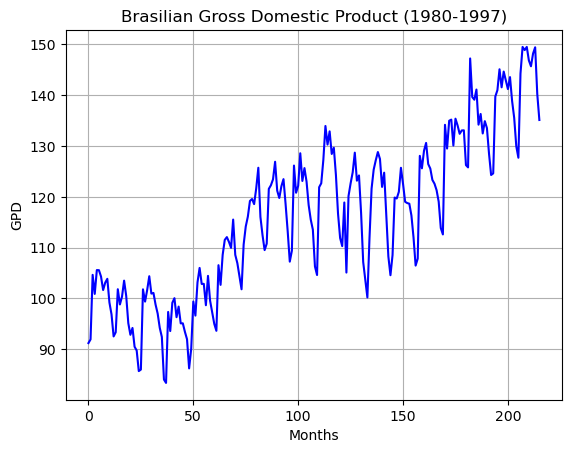

In [7]:
df.GPD.plot(color='blue')

plt.grid()
plt.xlabel('Months')
plt.ylabel('GPD')
plt.title('Brasilian Gross Domestic Product (1980-1997)')

plt.show()

### Train-test split

In [8]:
train_size = int(len(df.GPD) * 0.8)

series_train = df.GPD[:train_size].values
time_train = df.time[:train_size].values

series_test = df.GPD[train_size:].values
time_test = df.time[train_size:].values

### Training

Normalization

In [9]:
mmn = MinMaxNormalization(new_range=(0, 1))
mmn.fit(series_train)

series_train_norm = mmn.transform(series_train)
series_test_norm = mmn.transform(series_test)

print('Min value of time series:', series_train.min())
print('Max value of time series:', series_train.max())
print('Min value of normalized time series:', series_train_norm.min())
print('Max value of normalized time series:', series_train_norm.max())

Min value of time series: 83.37
Max value of time series: 134.17
Min value of normalized time series: 0.0
Max value of normalized time series: 1.0


Adjust the normalized data

In [10]:
lag = 2 # Size of lag
step_forward = 1 # Step forward to prediction

print('Number of lags:', lag)
print('Number of step forward:', step_forward)

# Sliding window or lag or lag method
X_train_norm, y_train_norm = sliding_window(series_train_norm, lag, step_forward)
X_test_norm, y_test_norm = sliding_window(series_test_norm, lag, step_forward)

Number of lags: 2
Number of step forward: 1


Training the model

In [23]:
L = 3 # Number of hidden neurons
random_state = 61 # random state

print(f'Number of hidden neuros: {L}')
print(f'Random state: {random_state}')

elm = ELMRegressor(L=L, random_state=random_state)
elm.fit(X_train_norm, y_train_norm)

y_train_pred_norm = elm.predict(X_train_norm)
y_test_pred_norm = elm.predict(X_test_norm)

Number of hidden neuros: 3
Random state: 61


Training the model: save and load model

In [24]:
# Save model
joblib.dump(elm, '../models/elm_reg.pkl')

['../models/elm_reg.pkl']

In [25]:
# Load model
elm = joblib.load('../models/elm_reg.pkl')

print(f'Number of hidden neurons: {elm.L}')
print(f'Random state: {elm.random_state}')

Number of hidden neurons: 3
Random state: 61


Revert the normalization

In [18]:
y_train_pred = mmn.inverse_transform(y_train_pred_norm)
y_test_pred = mmn.inverse_transform(y_test_pred_norm)

Adjust the data

In [19]:
# Sliding window or lag or lag method
X_train, y_train = sliding_window(series_train, lag, step_forward)
X_test, y_test = sliding_window(series_test, lag, step_forward)

In [20]:
print('Time series:', series_train[0:5])

print('\nInput matrix X:')
print(X_train[0:3])

print('\nTarget variable y:')
print(y_train[0:3])

Time series: [ 91.21  91.94 104.64 100.89 105.58]

Input matrix X:
[[ 91.21  91.94]
 [ 91.94 104.64]
 [104.64 100.89]]

Target variable y:
[[104.64]
 [100.89]
 [105.58]]


Mean squared error

In [21]:
train_mse = mse_function(y_train, y_train_pred)
test_mse = mse_function(y_test, y_test_pred)

print('Training MSE:', train_mse)
print('Testing MSE:', test_mse)

Training MSE: 30.98760224746282
Testing MSE: 38.738611656048434


### Visualization

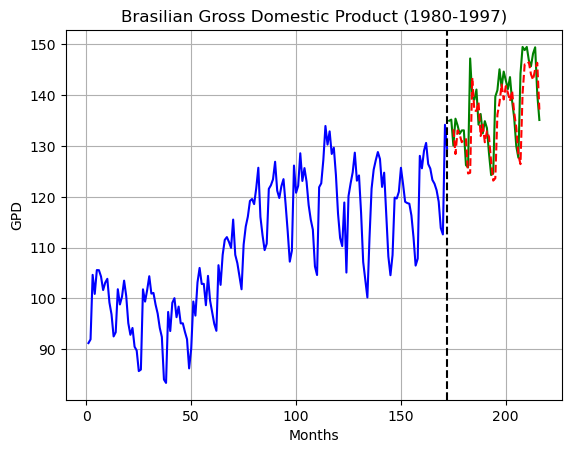

In [22]:
point = int((time_train[-1]+time_test[0])/2)

plt.plot(time_train, series_train, 'b')
plt.plot(time_test, series_test, 'g')
plt.plot(time_test[lag:], y_test_pred, 'r--')
plt.axvline(point, color='k', linestyle='--')

plt.grid()
plt.xlabel('Months')
plt.ylabel('GPD')
plt.title('Brasilian Gross Domestic Product (1980-1997)')

plt.show()